**Modèles épidémiologiques**
-

**Bárbara Barsi Duarte Batista da Silva**

**Rafaela de Carvalho Machado Pinheiro**


--- 

**_Library import_**

In [12]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

---

## Contexte
Il s'agit de voir les différences entre le modèle markovien et le modèle déterministe de la diffusion d'une épidémie. Vous devez rendre un fichier unique soit en pdf, soit en ipynb.

## Ce que vous avez à faire
- Ecrire un code qui résout et affiche le système déterministe SIR, prenant en entrée les paramètres beta et gamma (voir poly) 
- qui simule l'évolution du processus de Markov pour une population de N individus avec les mêmes paramètres beta et gamma
- Trouver des couples de valeurs (beta,gamma) où
    - tout le monde est retiré sur le long terme
    - il y a une partie de la population qui reste susceptible et une autre qui est retirée
- Illustrer sur des graphiques la convergence du processus de Markov renormalisé vers la solution du système déterministe


### SIR Model
The SIR model is widely used to estimate the spread of a disease through a population. In the model, the population is divided into 3 groups:
- $S$, susceptible: individuals who are not infected but can catch the disease. The size of this group can only decrease, as recovered/dead individuals are counted for in the "removed" group.
- $I$, infected: individuals who are currently infected and can transmit the disease to susceptibles. 
- $R$, removed: individuals who were infected and either recovered or died, meaning they do not transmit the disease anymore.

The deterministic SIR uses a system of Ordinary Differential Equations to show how these three groups evolve over time:  
  
The first equation models the change in the susceptible group, as they become infected after meeting infected individuals. This rate is also influenced by the transmission/infection rate of the disease, called $\beta$.
$$
\frac{dS}{dt} =  -\frac{\beta S I}{N}
$$

The second equation shows the change in the infected group. This group increases as more susceptibles are infected, but it decreases as the infected recover/die with rate $\gamma$.
$$
\frac{dI}{dt} = \frac{\beta S I}{N}  - \gamma I
$$

The last equation models the change in the removed group, which increases as infected individuals recover or die at rate $\gamma$.
$$
\frac{dR}{dt} = \gamma I
$$

The total population is $N$, thus $S+I+R=N$. Since we do not consider births or deaths unrelated to the disease, the population size remains constant.  
The initial value of $S$ is $N-I(0)$, as the whole population is susceptible except for infected individuals at first. Consequently, the initial value of $R$ is $0$.

The given dataset uses the total count of hospitalizations, deaths and recoveries, so it is more intuitive to model the equations by dividing the total size of each group ($S,I, R$)  by $N$. However, another possible notation would be to use them as fractions, with respect to the time:

$t$: $s(t)=S(t)/N \rightarrow ds/dt = -\beta s(t) i(t)$

First, we create a function to define the SIR system, using the equations above. We will use a list `y=[S(t), I(t), R(t)]` to simplify its parameters. Notice the `t` parameter and the `R` variables are not used directly in the function, they are stated to avoid conflicts when solving the ODE using the `odeint` function from the `Scipy` library (the function passed as the first parameter must receives all the other parameters of `odeint`, even if it is not going to use all of them).

In [13]:
def deriv_sir(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I/N
    dIdt = beta * S * I/N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

The following function sets the initial values for each group, then solves the ODEs system using the `odeint` function. This returns the values of $S, I, R$ in a vector, which is then transposed and stored into the S, I and R variables.

In [37]:
def SIR(beta, gamma, N):
    I0 = 1
    S0 = N - I0
    R0 = 0

    # time points in days
    t = np.linspace(0, 1000, 1000)
    y = S0, I0, R0


    res = odeint(deriv_sir, y, t, args=(N, beta, gamma)) # solve ODEs
    S, I, R = res.T

    return S, I, R, t


In [15]:
# plot simulation results
def plot_sir(S, I, R, t):
    plt.figure(figsize=(10, 6))
    plt.plot(t, S, label='Susceptible')
    plt.plot(t, I, label='Infected')
    plt.plot(t, R, label='Removed')
    plt.xlabel('Time (days)')
    plt.ylabel('Population')
    plt.title('SIR Model Simulation')
    plt.legend()
    plt.grid()
    plt.show()

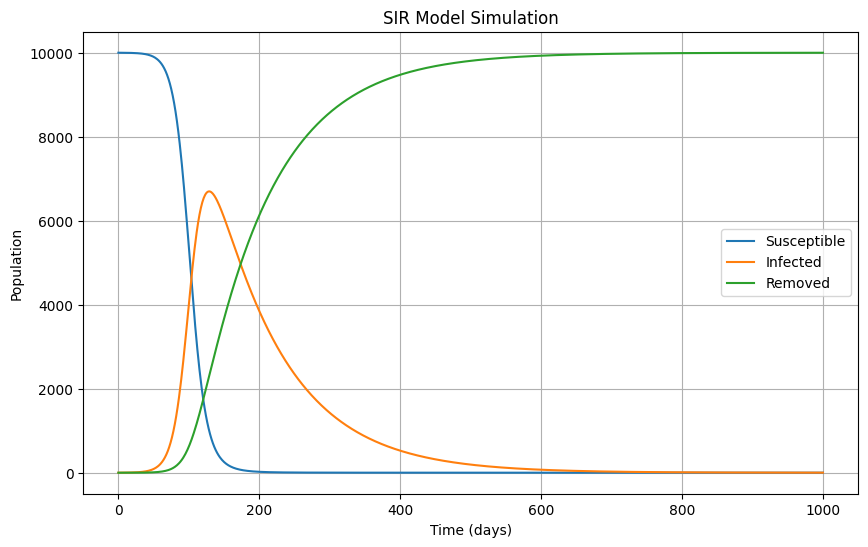

In [47]:
# example simulation
beta = 0.1  # infection rate
gamma = 0.01  # recovery rate
N = 10000  # total population

S, I, R, t = SIR(beta, gamma, N)
plot_sir(S, I, R, t)

### Markov Model
The Markovian model describes the spread of a disease in a stochastic way, unlike the deterministic SIR model. Similar to the previous model, the states of the system are now defined by the number of susceptible individuals $S$, the number of infected individuals $I$, and the number of removed individuals $R$. However, their evolution is determined by random events - new infections and new removals - which happend at random exponentially distibuted times.  
At any moment, we have:  
- The infection rate, proportional to the number of susceptible and infected individuals
$$
\lambda_{inf} = \beta \frac{SI}{N}
$$
where $\beta$ is the infection rate
- The recovery rate, proportional to the number of infected individuals
$$
\lambda_{rec} = \frac{\lambda}{N}
$$
where $\lambda$ is the recovery rate  
Thus, the total rate is $\lambda = \lambda_{inf} + \lambda_{rec}$

In [17]:
def exp(_lambda):
    U = np.random.rand()
    return - np.log(U) / _lambda

In [18]:
def markov(N, beta, gamma, I0=10, R0=0, t_max=100):
    S = N - I0 - R0
    I = I0
    R = R0

    # list of times
    t = [0]
    S_list = [S]
    I_list = [I]
    R_list = [R]

    current_time = 0

    while current_time < t_max and I > 0:
        inf_rate = beta * S * I / N
        rec_rate = gamma * I
        total_rate = inf_rate + rec_rate

        if total_rate == 0:
            print("No more infections possible")
            break

        dt = exp(total_rate)
        current_time += dt

        if np.random.rand() < inf_rate / total_rate:
            S -= 1
            I += 1
        else:
            I -= 1
            R += 1

        t.append(current_time)
        S_list.append(S)
        I_list.append(I)
        R_list.append(R)

    return np.array(S_list), np.array(I_list), np.array(R_list), np.array(t)


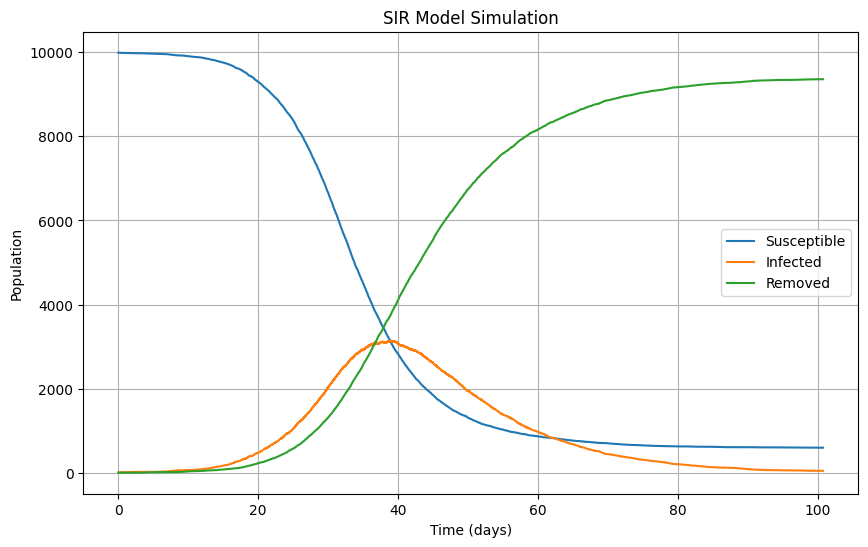

In [19]:
# example simulation with same parameters as SIR model
S, I, R, t = markov(N, beta, gamma)
plot_sir(S, I, R, t)


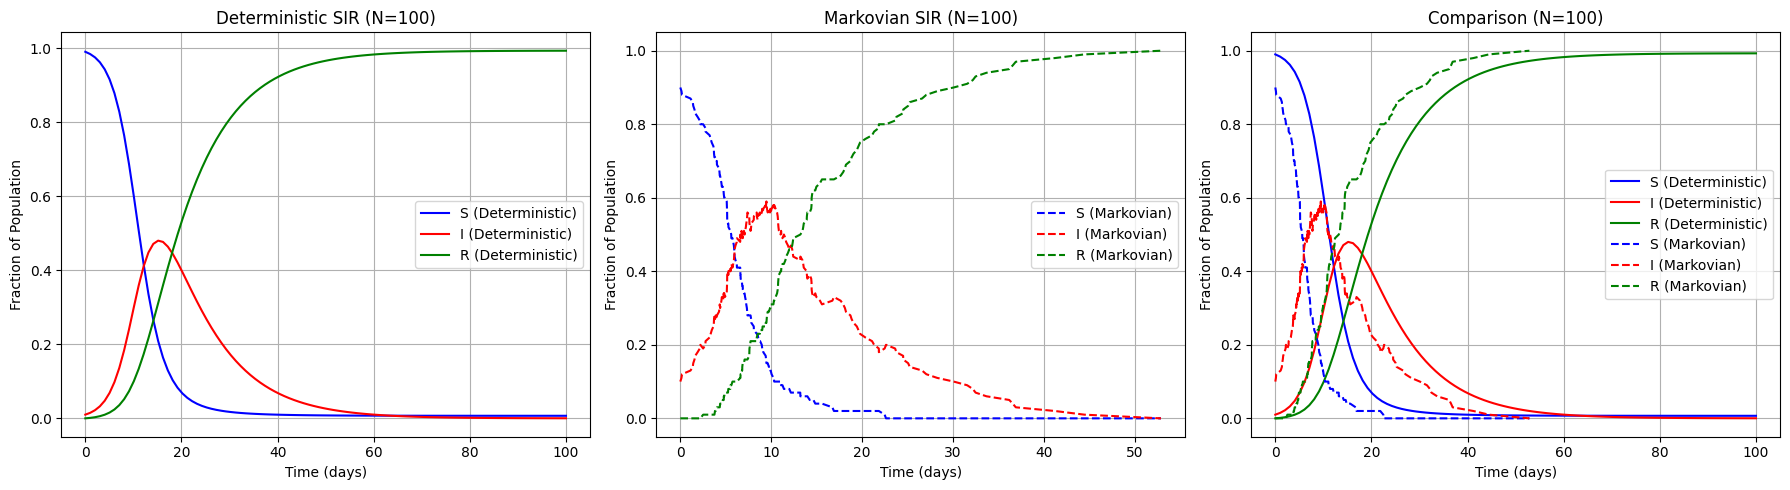

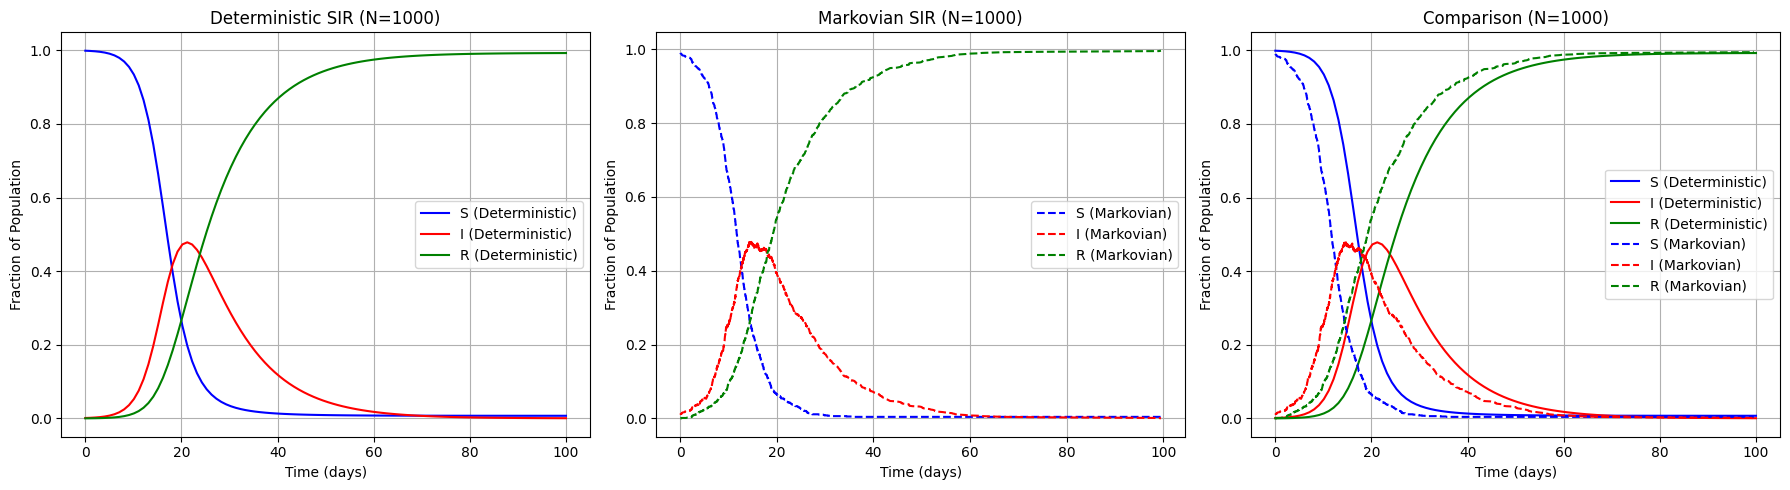

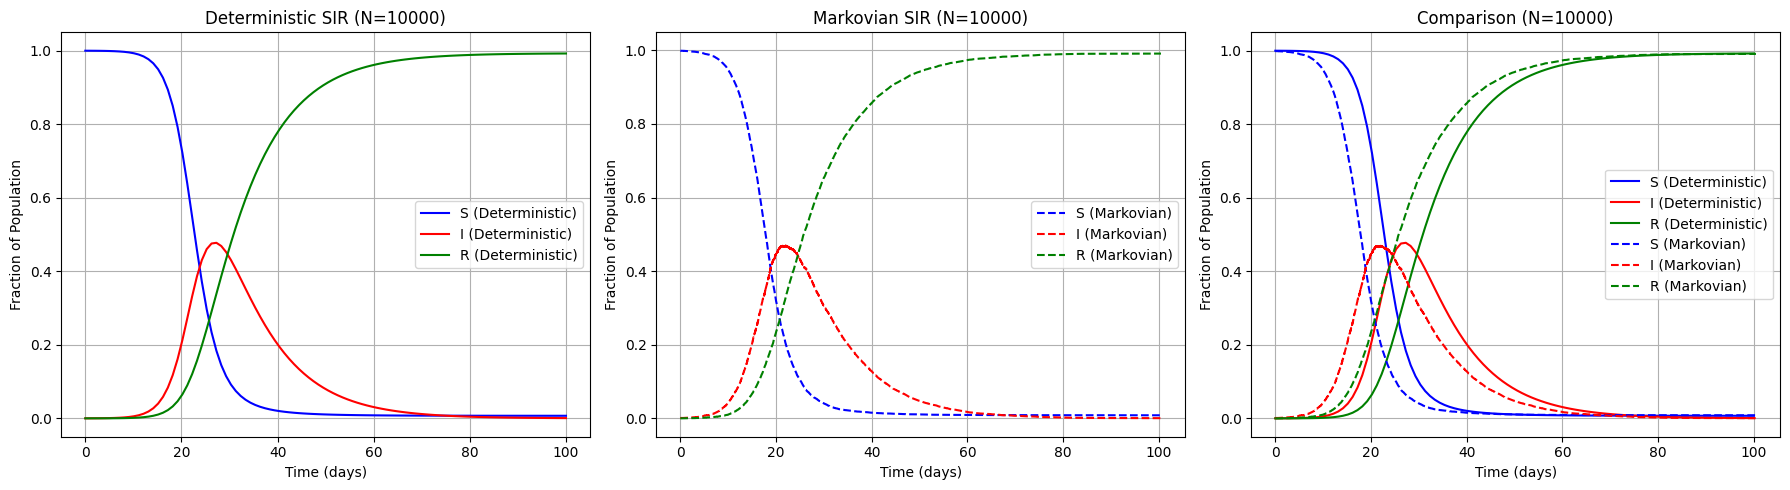

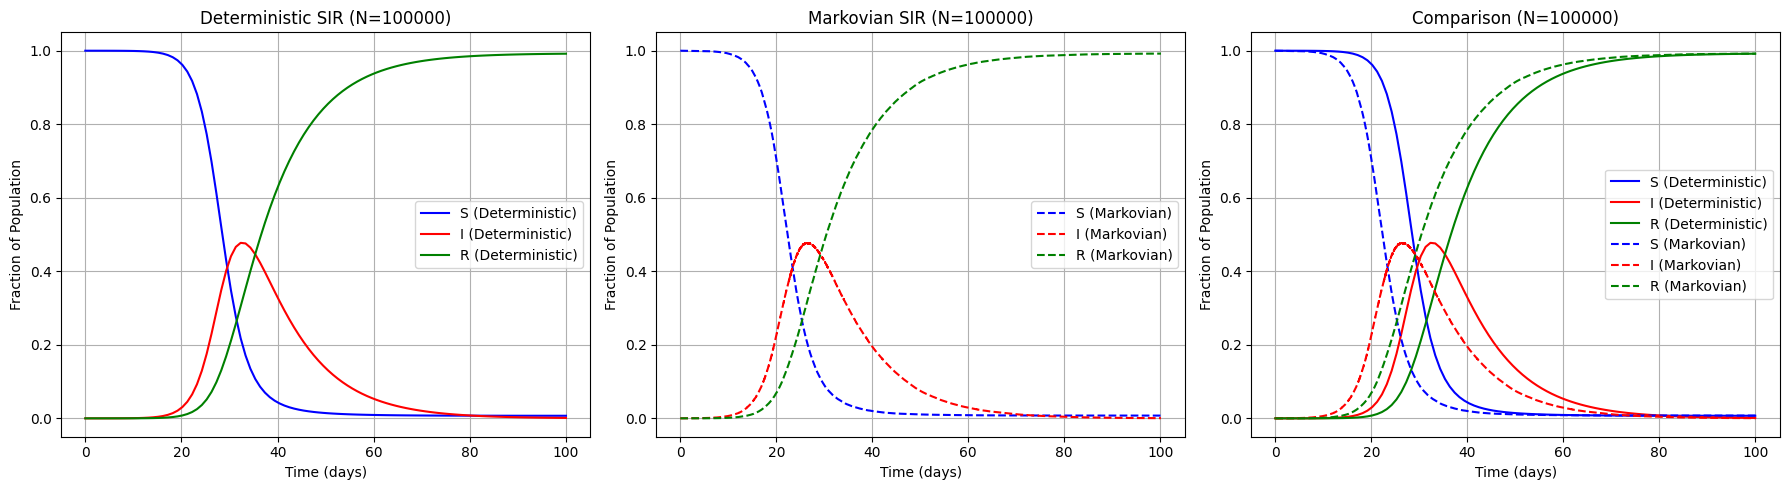

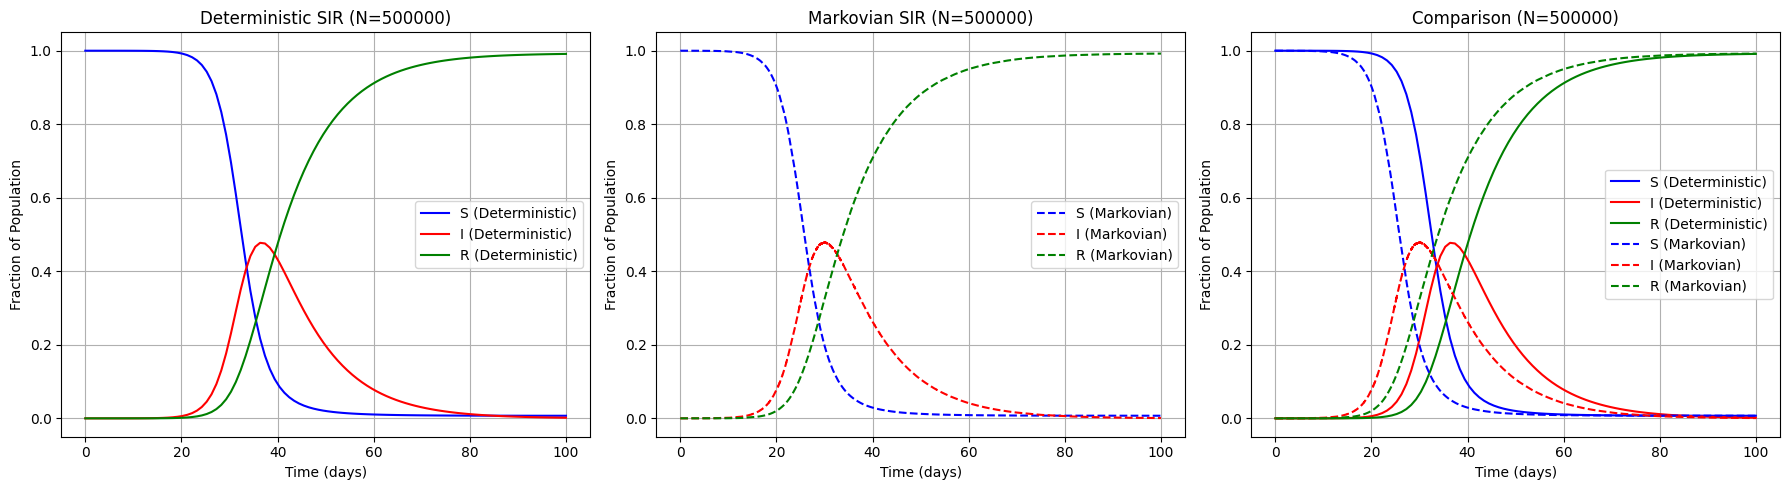

In [20]:
def simulations(population_list, beta, gamma):
    for N in population_list:
        # deterministic sir
        S_det, I_det, R_det, t_det = SIR(beta, gamma, N)

        # markovian
        S_markov, I_markov, R_markov, t_markov = markov(N, beta, gamma)

        # plot
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))

        # deterministic sir plot
        axs[0].plot(t_det, S_det / N, label='S (Deterministic)', color='blue')
        axs[0].plot(t_det, I_det / N, label='I (Deterministic)', color='red')
        axs[0].plot(t_det, R_det / N, label='R (Deterministic)', color='green')
        axs[0].set_title(f'Deterministic SIR (N={N})')
        axs[0].set_xlabel('Time (days)')
        axs[0].set_ylabel('Fraction of Population')
        axs[0].legend()
        axs[0].grid(True)

        # markovian plot
        axs[1].plot(t_markov, S_markov / N, label='S (Markovian)', color='blue', linestyle='--')
        axs[1].plot(t_markov, I_markov / N, label='I (Markovian)', color='red', linestyle='--')
        axs[1].plot(t_markov, R_markov / N, label='R (Markovian)', color='green', linestyle='--')
        axs[1].set_title(f'Markovian SIR (N={N})')
        axs[1].set_xlabel('Time (days)')
        axs[1].set_ylabel('Fraction of Population')
        axs[1].legend()
        axs[1].grid(True)

        # comparison plot
        axs[2].plot(t_det, S_det / N, label='S (Deterministic)', color='blue')
        axs[2].plot(t_det, I_det / N, label='I (Deterministic)', color='red')
        axs[2].plot(t_det, R_det / N, label='R (Deterministic)', color='green')

        axs[2].plot(t_markov, S_markov / N, '--', label='S (Markovian)', color='blue')
        axs[2].plot(t_markov, I_markov / N, '--', label='I (Markovian)', color='red')
        axs[2].plot(t_markov, R_markov / N, '--', label='R (Markovian)', color='green')

        axs[2].set_title(f'Comparison (N={N})')
        axs[2].set_xlabel('Time (days)')
        axs[2].set_ylabel('Fraction of Population')
        axs[2].legend()
        axs[2].grid(True)

        plt.tight_layout()
        plt.show()

populations = [100, 1000, 10000, 100000, 500000]
beta = 0.5
gamma = 0.1

simulations(populations, beta, gamma)


---

#### Find $\beta$ and $\gamma$ when
1. Everyone is removed eventually
2. Some part of the population remains susceptible, others are removed

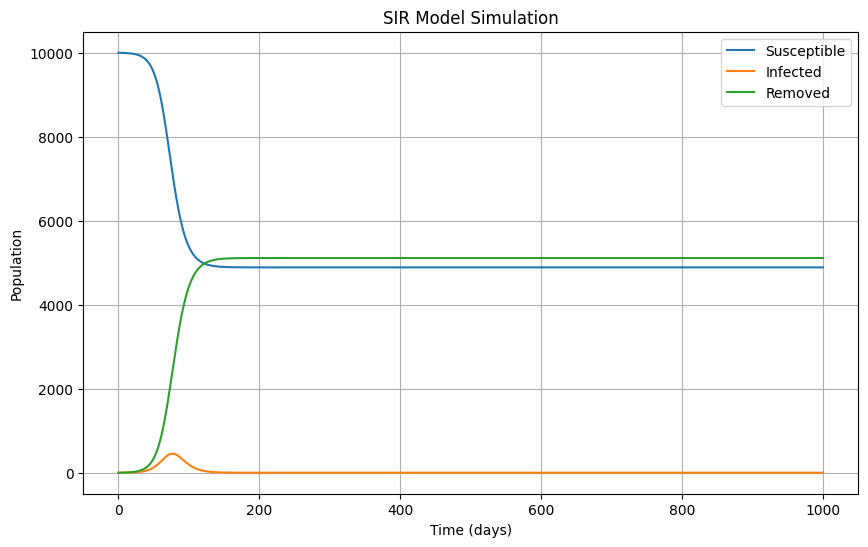

In [60]:
gamma = 0.25
beta = 0.35

S, I, R, t = SIR(beta, gamma, N)
plot_sir(S, I, R, t)

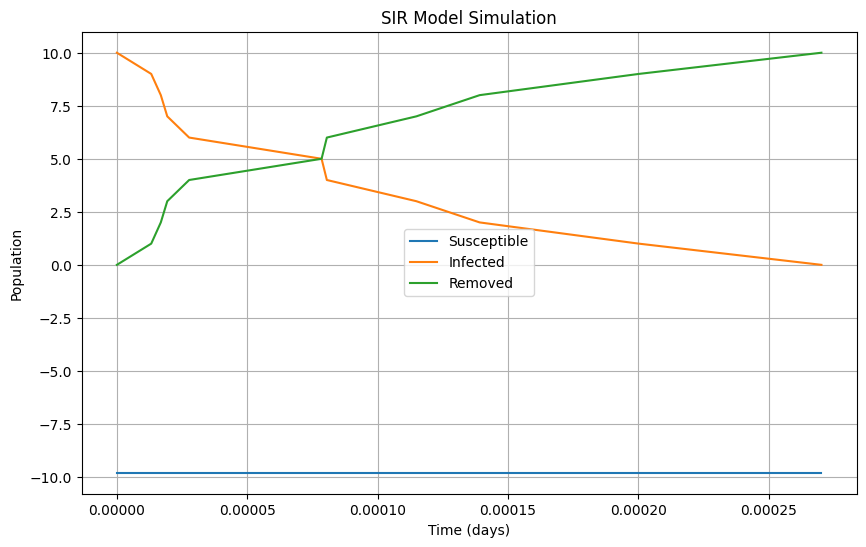

In [62]:
gamma = 0.3
beta = 0.2

S, I, R, t = markov(beta, gamma, N)
plot_sir(S, I, R, t)

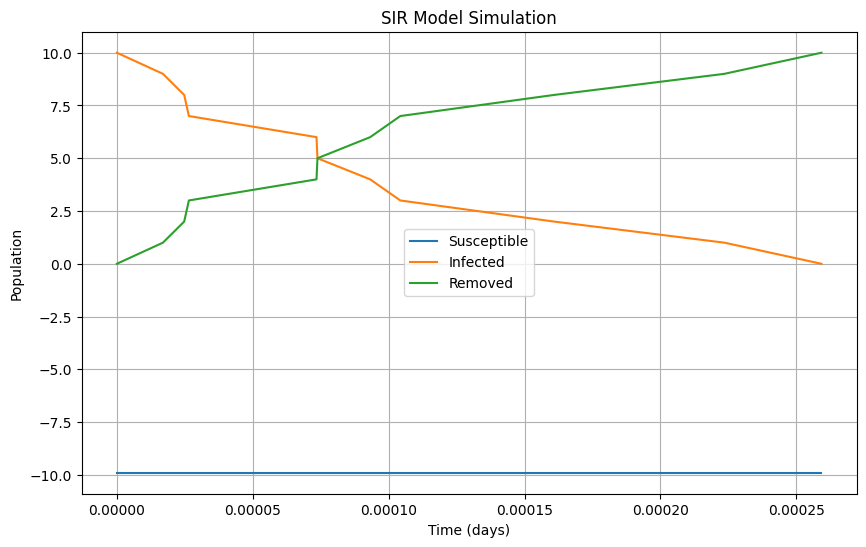

In [61]:
gamma = 0.01
beta = 0.1

S, I, R, t = markov(beta, gamma, N)
plot_sir(S, I, R, t)

---

### Question ouverte avec différentes réponses possibles 
A partir des données de Santé Publique France, <https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/>, notamment le fichier "donnees_hospitalieres_nouveaux_covid19..." qui comportent 4 colonnes : les hospitalisations (hos), les admissions en réanimation (rea), les décès (dc) et les retournés à la maison (rad) pour chaque jour et pour chaque département, **comment feriez-vous pour estimer gamma et beta sur un département donné ?**


### Code

The information retrieved Santé Publique France is stored in a `.csv`, so we are going to use the Python library `pandas` to visualize and manipulate the data.

In [21]:
data = pd.read_csv('donnees-covid.csv', sep=';')
print(data.head())

  dep        jour  incid_hosp  incid_rea  incid_dc  incid_rad
0   1  2020-03-19           1          0         0          0
1   1  2020-03-20           0          0         0          1
2   1  2020-03-21           3          0         0          0
3   1  2020-03-22           3          1         0          1
4   1  2020-03-23          14          1         0          5


In order to guide all the upcoming analysis, we regoing to focus specifically at the Paris département, with the code 75. 

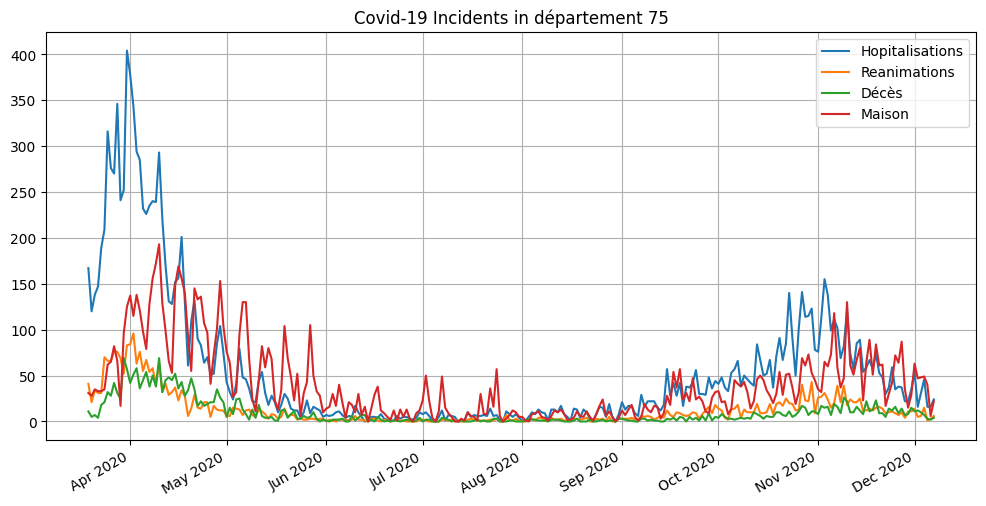

In [22]:
dep = '75'

data_plot = data[['dep', 'jour', 'incid_hosp', 'incid_rea', 'incid_dc', 'incid_rad']].copy()
data_plot = data_plot[data_plot.dep == dep]
data_plot['jour'] = pd.to_datetime(data_plot['jour'], format='%Y-%m-%d')
data_plot.set_index('jour', inplace=True)
data_plot = data_plot.sort_index()
# data_plot = data_plot.resample('D').sum()

plt.figure(figsize=(12, 6))
plt.plot(data_plot.index, data_plot['incid_hosp'], label='Hopitalisations')
plt.plot(data_plot.index, data_plot['incid_rea'], label='Reanimations')
plt.plot(data_plot.index, data_plot['incid_dc'], label='Décès')
plt.plot(data_plot.index, data_plot['incid_rad'], label='Maison')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # format as "Mar 2020" etc
plt.gcf().autofmt_xdate()  


plt.title(f'Covid-19 Incidents in département {dep}')
plt.grid(True)
plt.legend()
plt.show()

The SIR model is governed by the following :

$$
\frac{dS}{dt} = -\beta \frac{SI}{N}
$$

$$
\frac{dI}{dt} = \beta \frac{SI}{N} - \gamma I
$$

$$
\frac{dR}{dt} = \gamma I
$$

Given the previous differential equations defined for $S(t)$, $I(t)$, and $R(t)$, $\beta$ and $\gamma$ can be expressed as:

$$

$$

Approximate derivatives using finite differences:

$$
\frac{dS}{dt} \approx S(t+\Delta t) - S(t)
$$

$$
\frac{dR}{dt} \approx R(t+\Delta t) - R(t)
$$

Then estimate $\gamma$ by:

$$
\gamma(t) = \frac{R(t+\Delta t) - R(t)}{I(t)}
$$

and estimate $\beta$ by:

$$
\beta(t) = -\frac{N \times (S(t+\Delta t) - S(t))}{S(t) \times I(t)}
$$

Final estimates for $\beta$ and $\gamma$ can be obtained by averaging over time.